In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
import os
import sys

# Thêm thư mục src/ vào sys.path để import module
sys.path.append(r"D:\3\Hoc May\BTL\traffic_sign_project (1)\src")

from dataloader import get_dataloader
from transforms import train_transform, test_transform

# --- 1. DataLoader ---
csv_train = r"D:\3\Hoc May\BTL\traffic_sign_project (1)\data\raw_gtsrb\Train.csv"
csv_test = r"D:\3\Hoc May\BTL\traffic_sign_project (1)\data\raw_gtsrb\Test.csv"
root_dir = r"D:\3\Hoc May\BTL\traffic_sign_project (1)\data\raw_gtsrb"

train_loader = get_dataloader(csv_train, root_dir, train_transform, batch_size=64, shuffle=True)
test_loader = get_dataloader(csv_test, root_dir, test_transform, batch_size=64, shuffle=False)

# --- 2. Khởi tạo mô hình ResNet50 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Thay fully connected layer + Dropout để tránh overfitting
model.fc = nn.Sequential(
    nn.Dropout(0.5),                 # Dropout 50%
    nn.Linear(model.fc.in_features, 43)  # GTSRB có 43 lớp
)
model = model.to(device)


Using device: cpu


In [2]:
# --- 3. Loss & Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # weight_decay = L2 regularization


In [6]:
epochs = 10
best_acc = 0.0
patience, trigger_times = 3, 0   # Early stopping

save_dir = r"D:\3\Hoc May\BTL\traffic_sign_project (1)\models"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "resnet50_best.pth")

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    avg_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total
    val_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Test Acc: {test_acc:.4f}")
       # --- Save best model ---
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_path)
        print("✅ Saved new best model:", save_path)
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"⚠️ Early stopping counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("⛔ Early stopping triggered!")
            break

print("Best Test Accuracy:", best_acc)


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 613/613 [1:30:38<00:00,  8.87s/it]


Epoch 1/10, Loss: 0.0039, Train Acc: 0.9990, Val Loss: 0.0433, Test Acc: 0.9894
✅ Saved new best model: D:\3\Hoc May\BTL\traffic_sign_project (1)\models\resnet50_best.pth


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 613/613 [1:29:42<00:00,  8.78s/it]


Epoch 2/10, Loss: 0.0036, Train Acc: 0.9990, Val Loss: 0.0548, Test Acc: 0.9858
⚠️ Early stopping counter: 1/3


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 613/613 [1:32:14<00:00,  9.03s/it]


Epoch 3/10, Loss: 0.0022, Train Acc: 0.9995, Val Loss: 0.0579, Test Acc: 0.9862
⚠️ Early stopping counter: 2/3


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 613/613 [1:36:21<00:00,  9.43s/it]


Epoch 4/10, Loss: 0.0047, Train Acc: 0.9990, Val Loss: 0.0637, Test Acc: 0.9860
⚠️ Early stopping counter: 3/3
⛔ Early stopping triggered!
Best Test Accuracy: 0.989390340459224


                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        60
                              Speed limit (30km/h)       1.00      0.99      0.99       720
                              Speed limit (50km/h)       0.99      1.00      0.99       750
                              Speed limit (60km/h)       0.99      0.96      0.98       450
                              Speed limit (70km/h)       1.00      0.99      0.99       660
                              Speed limit (80km/h)       0.97      0.99      0.98       630
                       End of speed limit (80km/h)       0.99      0.97      0.98       150
                             Speed limit (100km/h)       1.00      1.00      1.00       450
                             Speed limit (120km/h)       1.00      1.00      1.00       450
                                        No passing       0.99      1.00      1.

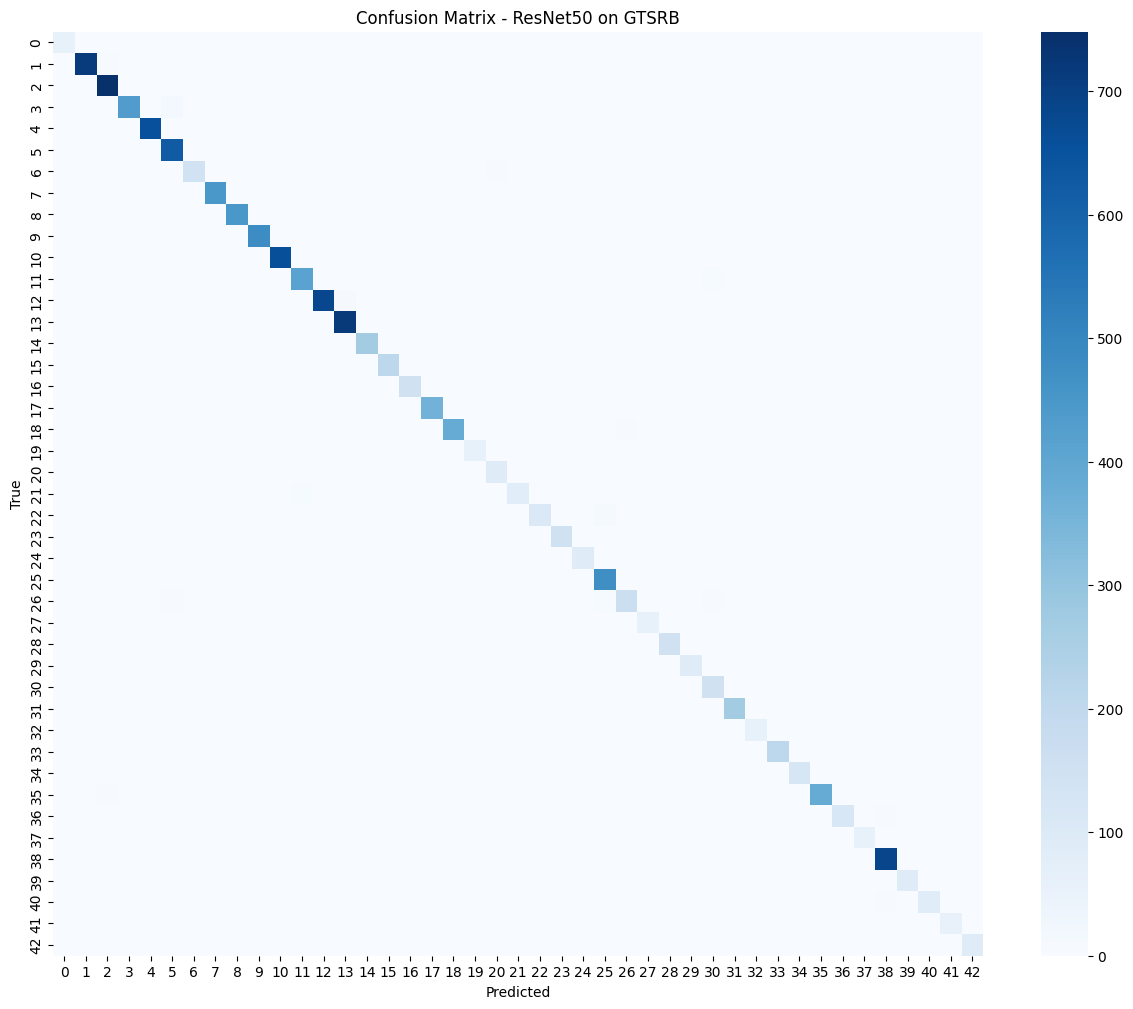

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Load signnames ---
signnames = pd.read_csv(r"D:\3\Hoc May\BTL\traffic_sign_project (1)\data\raw_gtsrb\signnames.csv")

# --- Load lại best model ---
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# --- In báo cáo chi tiết ---
print(classification_report(y_true, y_pred, target_names=signnames["SignName"]))

# --- Vẽ Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix - ResNet50 on GTSRB")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
